In [38]:
# Main code written by Morten Hjorth-Jensen
# Modified by Joseph P.Vera and Luis Jimenez

# Common imports
import os

# Where to save the figures and data files
PROJECT_ROOT_DIR = "Results"
FIGURE_ID = "Results/FigureFiles"
DATA_ID = "Results/VMCHarmonic"

if not os.path.exists(PROJECT_ROOT_DIR):
    os.mkdir(PROJECT_ROOT_DIR)

if not os.path.exists(FIGURE_ID):
    os.makedirs(FIGURE_ID)

if not os.path.exists(DATA_ID):
    os.makedirs(DATA_ID)

def image_path(fig_id):
    return os.path.join(FIGURE_ID, fig_id)

def data_path(dat_id):
    return os.path.join(DATA_ID, dat_id)

def save_fig(fig_id):
    plt.savefig(image_path(fig_id) + ".png", format='png')

outfile = open(data_path("VMCHarmonic.dat"),'w')

In [39]:
%matplotlib inline

# Brute force Metropolis, without importance sampling and no energy minimization
from math import exp, sqrt
from random import random, seed
import numpy as np
import matplotlib.pyplot as plt
from decimal import *
 
# Trial wave function for the Harmonic oscillator in generalized form (Generalized equation)
# betha = 1
def WaveFunction(r,alpha):
    sum = 0
    for i in range(N):
        for j in range(D):
            sum += r[i,j]*r[i,j]
    return exp(-alpha*sum)

# Local energy  for the Harmonic oscillator in generalized form (Generalized equation)
def LocalEnergy(r,alpha):
    sum1 = 0
    for i in range(N):
        for j in range(D):
            sum1 += r[i,j]*r[i,j] 
    return (0.5 - 2*alpha*alpha)*sum1 + N*D*alpha

In [40]:
# The Monte Carlo sampling with the Metropolis algorithm
# The argument types will be inferred by Numba when the function is called.
def MonteCarloSampling():

    NumberMCcycles= 1000000  # 7 zeros (Number of cycles)
    StepSize = 1.0
    # positions
    PositionOld = np.zeros((N,D), np.double)    # Position of the particles
    PositionNew = np.zeros((N,D), np.double)    # Position of the particles

    # seed for random number generator
    seed()
    # start variational parameter
    alpha = 0.1
    for ia in range(MaxVariations):
        alpha += .05
        AlphaValues[ia] = alpha
        energy = energy2 = 0.0      # Initial conditions
        DeltaE = 0.0                # Initial conditions
        #Initial position
        for i in range(N):
            for j in range(D):
                PositionOld[i,j] = StepSize * (random() - .5)
        wfold = WaveFunction(PositionOld,alpha)
        
        # Loop over MC MCcycles
        for MCcycle in range(NumberMCcycles):
            # Trial position 
            for i in range(N):
                for j in range(D):
                    PositionNew[i,j] = PositionOld[i,j] + StepSize*(random() - .5)
                wfnew = WaveFunction(PositionNew,alpha)
                # Metropolis test to see whether we accept the move
                if random() <= wfnew**2 / wfold**2:
                   for j in range(D):
                       PositionOld[i,j] = PositionNew[i,j]
                   wfold = wfnew
            DeltaE = LocalEnergy(PositionOld,alpha)
            energy += DeltaE
            energy2 += DeltaE**2
        # We calculate mean, variance and error
        energy /= NumberMCcycles
        energy2 /= NumberMCcycles
        variance = energy2 - energy**2
        error = sqrt(variance/NumberMCcycles)
        Energies[ia] = energy    
        Variances[ia] = variance    
        outfile.write('%f %f %f %f \n' %(alpha,energy,variance,error))   # Save the information
    return Energies, AlphaValues, Variances

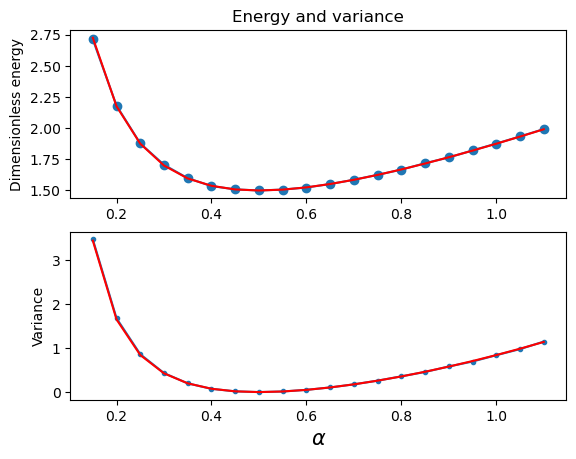

    Alpha    Energy  Exact Energy  Variance  Exact Variance
0    0.15  2.711056      2.725000  3.480536        3.450417
1    0.20  2.180202      2.175000  1.682098        1.653750
2    0.25  1.877169      1.875000  0.862961        0.843750
3    0.30  1.706031      1.700000  0.432629        0.426667
4    0.35  1.598564      1.596429  0.198579        0.199056
5    0.40  1.535318      1.537500  0.074178        0.075938
6    0.45  1.509013      1.508333  0.016642        0.016713
7    0.50  1.500000      1.500000  0.000000        0.000000
8    0.55  1.507298      1.506818  0.013638        0.013667
9    0.60  1.523832      1.525000  0.050909        0.050417
10   0.65  1.551887      1.551923  0.105874        0.105643
11   0.70  1.585997      1.585714  0.176543        0.176327
12   0.75  1.625611      1.625000  0.260474        0.260417
13   0.80  1.667069      1.668750  0.358740        0.356484
14   0.85  1.718801      1.716176  0.458380        0.463508
15   0.90  1.764856      1.766667  0.583

In [41]:
import time
inicio = time.time()
#############################################################################################################################################
# Values for N and D can be changed. N take values {1,2,3,...,500,...} and D is given by {1,2,3}
N=1  # Number of particles
D=3  # Dimensions
MaxVariations = 20
Energies = np.zeros((MaxVariations))
ExactEnergies = np.zeros((MaxVariations))
ExactVariance = np.zeros((MaxVariations))
Variances = np.zeros((MaxVariations))
AlphaValues = np.zeros(MaxVariations)
(Energies, AlphaValues, Variances) = MonteCarloSampling()
outfile.close()
ExactEnergies = (0.5 - 2*AlphaValues*AlphaValues)*((D*N)/(4*AlphaValues)) + D*N*AlphaValues   # Generalized energy equation
ExactVariance = 0.0625*N*D*((D+2)/(AlphaValues*AlphaValues))*(0.5 - 2*AlphaValues*AlphaValues)**2 + 0.5*N*(0.5 - 2*AlphaValues*AlphaValues)*D**2 + N*(D*AlphaValues)**2  - (1/N)*ExactEnergies*ExactEnergies   # Generalization Variance equation  
# Plot
plt.subplot(2, 1, 1)
plt.plot(AlphaValues, Energies, 'o-',AlphaValues, ExactEnergies,'r-')
plt.title('Energy and variance')
plt.ylabel('Dimensionless energy')
plt.subplot(2, 1, 2)
plt.plot(AlphaValues, Variances, '.-',AlphaValues, ExactVariance,'r-')
plt.xlabel(r'$\alpha$', fontsize=15)
plt.ylabel('Variance')
save_fig("VMCHarmonic")
plt.show()

# Using Pandas
import pandas as pd
from pandas import DataFrame
data ={'Alpha':AlphaValues, 'Energy':Energies,'Exact Energy':ExactEnergies,'Variance':Variances,'Exact Variance':ExactVariance,}
frame = pd.DataFrame(data)
print(frame)
#############################################################################################################################################
fin = time.time()
print("---------------------------------------------------------------")
print("---------------------------------------------------------------")
print("CPU time =",fin-inicio, "seconds")
print("CPU time =",(fin-inicio)/60, "minutes")
print("CPU time =",(fin-inicio)/3600, "hours")
print("---------------------------------------------------------------")
print("---------------------------------------------------------------")